## Where and When Should I Not Be Parking Illegally in NYC?

In [21]:
import os
import pandas as pd
import geopandas as gpd
import subprocess
from geopandas.tools import geocode
import re
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%matplotlib inline
#%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120
#%matplotlib notebook

In [22]:
data_folder = '/Users/geoffperrin/Desktop/python_sandbox/NYPD/data'

### Read in NYPD parking data

In [23]:
'''
taken from:
https://data.cityofnewyork.us/Social-Services/nypd-7-major-felony-incidents/k384-xu3q/data
filtered to Agency: NYPD
Complaint Type: Illegal Parking
'''

nypd_df_raw = pd.read_csv(data_folder+'/nypd_7_major_felony_incidents.csv')
nypd_df = nypd_df_raw[['Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', \
                       'Community Board', 'Borough', 'Latitude', 'Longitude']]

#subset to just blocked sidewalks
nypd_df = nypd_df[nypd_df.Descriptor == "Blocked Sidewalk"]
nypd_df.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Community Board,Borough,Latitude,Longitude
9,09/04/2015 08:52:01 PM,09/04/2015 11:24:31 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,05 QUEENS,QUEENS,40.722005,-73.904019
37,09/04/2015 04:43:36 PM,09/04/2015 10:15:45 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,03 STATEN ISLAND,STATEN ISLAND,40.562832,-74.148151
46,09/04/2015 08:46:01 AM,09/04/2015 12:14:42 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,02 STATEN ISLAND,STATEN ISLAND,40.593806,-74.075633
54,09/05/2015 12:03:41 AM,NaN,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,0 Unspecified,Unspecified,NaN,NaN
57,09/04/2015 07:17:15 PM,09/05/2015 02:51:48 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,01 BROOKLYN,BROOKLYN,40.713757,-73.936055


In [24]:
nypd_df['create_date_time'] = pd.to_datetime(nypd_df['Created Date'])
nypd_df['closed_date_time'] = pd.to_datetime(nypd_df['Closed Date'])

In [25]:
nypd_df['create_date'] = nypd_df['create_date_time'].dt.date
nypd_df['day_of_week'] = nypd_df.create_date.apply(lambda x: x.weekday())

#control for Friday / Saturday nights
nypd_df['weekend'] = 0
nypd_df['weekend'][(nypd_df['day_of_week'] == 4) | (nypd_df['day_of_week'] == 5)] = 1

#control for hour of day
nypd_df['hour_of_day'] = nypd_df.create_date_time.apply(lambda x: x.hour)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
nypd_df.sort(['create_date_time']).head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Community Board,Borough,Latitude,Longitude,create_date_time,closed_date_time,create_date,day_of_week,weekend,hour_of_day
133642,06/03/2010 03:41:11 PM,06/03/2010 04:49:08 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,05 MANHATTAN,MANHATTAN,40.762334,-73.980370,2010-06-03 15:41:11,2010-06-03 16:49:08,2010-06-03,3,0,15
133666,06/03/2010 04:09:26 PM,06/03/2010 04:23:23 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,06 MANHATTAN,MANHATTAN,40.747629,-73.976736,2010-06-03 16:09:26,2010-06-03 16:23:23,2010-06-03,3,0,16
133653,06/03/2010 05:41:12 PM,06/04/2010 07:18:51 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,01 STATEN ISLAND,STATEN ISLAND,40.618095,-74.086207,2010-06-03 17:41:12,2010-06-04 07:18:51,2010-06-03,3,0,17
133643,06/03/2010 07:14:56 PM,06/04/2010 12:21:08 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,09 MANHATTAN,MANHATTAN,40.814067,-73.960362,2010-06-03 19:14:56,2010-06-04 00:21:08,2010-06-03,3,0,19
133768,06/04/2010 06:55:34 AM,06/04/2010 11:06:31 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,18 BROOKLYN,BROOKLYN,40.639118,-73.910998,2010-06-04 06:55:34,2010-06-04 11:06:31,2010-06-04,4,1,6


### Time Series of Counts 

In [27]:
nypd_count_df = nypd_df.groupby(['create_date'], as_index=False)['Agency'].count()
nypd_count_df.columns = ['create_date', 'sidewalk_parking_count']

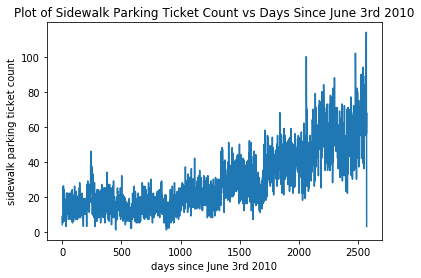

In [28]:
plt.plot(nypd_count_df[['sidewalk_parking_count']])
plt.xlabel('days since June 3rd 2010')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Days Since June 3rd 2010')

Note: I don't have a way to account for changes in vehicle counts across time, as I only have the ACS snapshot for 2015. However, since we are dealing with a relatively short 7 year period, I think it's safe to assume the vehicle count across the entire city is relatively constant across that time. With that assumption in place, we can see a gradual increase in the count of sidewalk parking tickets across the time span.

### Count by Hour of Day

In [29]:
nypd_hour_df = nypd_df.groupby(['hour_of_day'], as_index=False)['Agency'].count()
nypd_hour_df.columns = ['hour_of_day', 'sidewalk_parking_count']

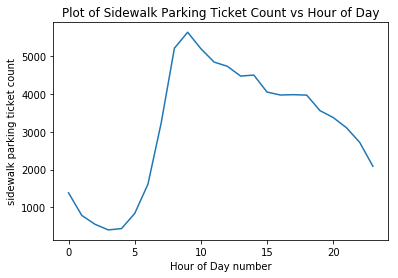

In [30]:
plt.plot(nypd_hour_df[['sidewalk_parking_count']])
plt.xlabel('Hour of Day number')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Hour of Day')

We can see a spike in the count of sidewalk parking tickets in the morning at 9am, and a gradual decline as the day wears on.

### Count by Day of Week

In [31]:
nypd_day_df = nypd_df.groupby(['day_of_week'], as_index=False)['Agency'].count()
nypd_day_df.columns = ['day_of_week', 'sidewalk_parking_count']

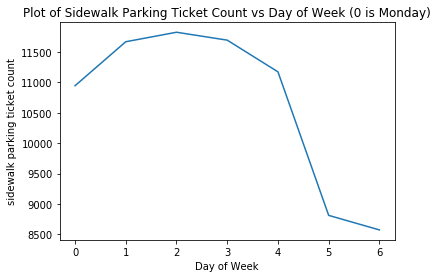

In [32]:
plt.plot(nypd_day_df[['sidewalk_parking_count']])
plt.xlabel('Day of Week')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Day of Week (0 is Monday)')

Looks like ticket count drops off dramatically on Saturdays and Sundays, indicating the ticketers really are only working on weekdays.

### Count by Day of Week / Hour of Day

In [33]:
nypd_day_hour_df = nypd_df.groupby(['day_of_week', 'hour_of_day'], as_index=False)['Agency'].count()
nypd_day_hour_df.columns = ['day_of_week', 'hour_of_day', 'sidewalk_parking_count']

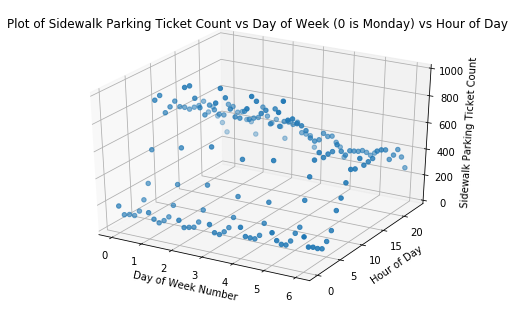

In [34]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(nypd_day_hour_df.day_of_week, nypd_day_hour_df.hour_of_day, nypd_day_hour_df.sidewalk_parking_count)
ax.set_xlabel('Day of Week Number')
ax.set_ylabel('Hour of Day')
ax.set_zlabel('Sidewalk Parking Ticket Count')
ax.set_title('Plot of Sidewalk Parking Ticket Count vs Day of Week (0 is Monday) vs Hour of Day')
plt.show()

### Read in ACS Data

In [35]:
'''
taken from: 
https://public.enigma.com/datasets/household-size-by-vehicles-available/f9d2a838-00ce-4d17-90bb-9a20e22f515a?filter=%2B%5B%3Estusab%5BNY%5D%5D
'''
acs_df_raw = pd.read_csv(data_folder+'/ACS_vehicle_data.csv')
#subset to just NYC
acs_df = acs_df_raw[(acs_df_raw.b08201_001 == "795") & (acs_df_raw.sumlevel == "NY")]
acs_nyc_df = acs_df[acs_df['name'].str.contains("NYC")]
acs_nyc_df = acs_nyc_df.iloc[:,0:17]
acs_nyc_df.columns = ['name', 'name2', 'geoid', 'state', 'summary_level', 'total_pop',\
                     'total_pop_moe', 'no_vehicle_pop', 'no_vehicle_pop_moe',\
                     'one_vehicle_pop', 'one_vehicle_pop_moe', 'two_vehicle_pop',\
                     'two_vehicle_pop_moe', 'three_vehicle_pop', 'three_vehicle_pop_moe',\
                     'four_or_more_vehicle_pop', 'four_or_more_vehicle_pop_moe']
#acs_nyc_df = acs_nyc_df[acs_nyc_df.total_pop!="None"]

### Do a little regex stuff to get useable x-walk for community district name

In [36]:
# Harmonize community district name for ACS

dict_boro2 = {'Bronx': 'BX', 'Brooklyn': 'BK', 'Manhattan': 'MN', 'Staten': 'SI', 'Queens': 'QN'}

def add_zero(f):
    if len(f) == 1:
        return '0'+f
    else:
        return f

acs_nyc_df['cd_num'] = [re.search("[0-9]+", i).group(0) for i in acs_nyc_df['name']]
acs_nyc_df['cd_num_2'] = [add_zero(i) for i in acs_nyc_df['cd_num']]

acs_nyc_df['boro'] = [dict_boro2[re.search('[^\s]+', i[4:]).group(0)] for i in acs_nyc_df['name']]

acs_nyc_df['cd_id'] = acs_nyc_df['boro'] + acs_nyc_df['cd_num_2']

In [37]:
acs_nyc_df = acs_nyc_df.replace(to_replace="None", value=0)

In [38]:
acs_nyc_df = acs_nyc_df.replace(to_replace="None", value=0)
acs_nyc_df = acs_nyc_df[['cd_id', 'boro', 'total_pop', 'no_vehicle_pop', 'one_vehicle_pop', 'two_vehicle_pop', \
                         'three_vehicle_pop', 'four_or_more_vehicle_pop']]
acs_nyc_df['vehicle_pop'] = acs_nyc_df['one_vehicle_pop'].astype(int) + 2*acs_nyc_df['two_vehicle_pop'].astype(int) + \
                            3*acs_nyc_df['three_vehicle_pop'].astype(int) + 4*acs_nyc_df['four_or_more_vehicle_pop'].astype(int)

acs_nyc_df['total_pop'] = acs_nyc_df['total_pop'].astype(int)
acs_nyc_df = acs_nyc_df[['cd_id', 'boro', 'total_pop', 'vehicle_pop']]
acs_nyc_df.head()

,cd_id,boro,total_pop,vehicle_pop
3252,MN06,MN,0,0
4426,BX08,BX,41340,31602
4427,BX12,BX,47321,38848
4428,BX10,BX,47025,43162
4429,BX11,BX,43622,34441


### Merge ACS data to NYPD data

In [39]:
nypd_df['cd_num'] = nypd_df['Community Board'].str.split(' ', 1).str[0]
nypd_df['cd_boro'] = nypd_df['Community Board'].str.split(' ', 1).str[1]

In [40]:
# Harmonize identifier

dict_boro = {'BRONX': 'BX', 'BROOKLYN': 'BK', 'MANHATTAN': 'MN', 'STATEN ISLAND': 'SI', 'QUEENS': 'QN'}

nypd_df['cd_num'] = nypd_df['Community Board'].str.split(' ', 1).str[0]
nypd_df['cd_boro'] = nypd_df['Community Board'].str.split(' ', 1).str[1]

nypd_df['cd_id'] = nypd_df['cd_boro'].map(dict_boro) + nypd_df['cd_num']
nypd_df['day_hour'] = pd.to_datetime(nypd_df['create_date'].astype(str) + ' ' + nypd_df['hour_of_day'].astype(str)+':00')
nypd_time_df = nypd_df.groupby(['cd_id', 'day_hour'], as_index=False)['Agency'].count()
nypd_time_df.columns = ['cd_id', 'day_hour', 'sidewalk_parking_count']

In [41]:
### drop bad community districts
nypd_time_df = nypd_time_df.dropna()
nypd_time_df = nypd_time_df[nypd_time_df.cd_id.str[2:]!="Unspecified"]
nypd_time_df = nypd_time_df[nypd_time_df['cd_id'].str[2:].astype(int)<=18]

In [42]:
nypd_time_df.head()

,cd_id,day_hour,sidewalk_parking_count
0,BK01,2010-06-09 13:00:00,1
1,BK01,2010-06-09 18:00:00,1
2,BK01,2010-06-10 23:00:00,1
3,BK01,2010-06-11 16:00:00,1
4,BK01,2010-06-15 14:00:00,1


In [43]:
#generate hourly date range for same number of weeks as mta data.
hours = pd.date_range('6/9/2010', periods=(24*365*7)+(24*10), freq='H')
blank_df = pd.DataFrame(columns=['cd_id','day_hour', 'sidewalk_parking_count'])
for i in nypd_time_df['cd_id'].unique():
    temp_df = pd.DataFrame(columns=['cd_id','day_hour', 'sidewalk_parking_count'])
    temp_df['day_hour'] = hours
    temp_df['sidewalk_parking_count'] = 0
    temp_df['cd_id'] = str(i)
    blank_df = pd.concat([blank_df, temp_df])

nypd_time_df = blank_df.merge(nypd_time_df, on=['cd_id', 'day_hour'], how='left')
nypd_time_df = nypd_time_df.fillna(0)
nypd_time_df = nypd_time_df[['cd_id', 'day_hour', 'sidewalk_parking_count_y']]
nypd_time_df.columns = ['cd_id', 'day_hour', 'sidewalk_parking_count']
nypd_time_df.head()

,cd_id,day_hour,sidewalk_parking_count
0,BK01,2010-06-09 00:00:00,0.0
1,BK01,2010-06-09 01:00:00,0.0
2,BK01,2010-06-09 02:00:00,0.0
3,BK01,2010-06-09 03:00:00,0.0
4,BK01,2010-06-09 04:00:00,0.0


In [50]:
nypd_cd_acs_df = nypd_time_df.merge(acs_nyc_df, on='cd_id', how='left')
nypd_cd_acs_df['boro'] = nypd_cd_acs_df['cd_id'].str[:2]
nypd_cd_acs_df = nypd_cd_acs_df.fillna(0)

In [52]:
#replace missing cd stats with boro averages
replace_df = acs_nyc_df[acs_nyc_df.total_pop > 0]
replace_df = replace_df.groupby(['boro'], as_index=False)['total_pop', 'vehicle_pop'].mean()

In [53]:
nypd_cd_acs_df = nypd_cd_acs_df.merge(replace_df, on='boro', how='left')

In [54]:
nypd_cd_acs_df['total_pop_x'] = np.where(nypd_cd_acs_df['total_pop_x'] == 0, nypd_cd_acs_df['total_pop_y'],\
                                          nypd_cd_acs_df['total_pop_x'])
nypd_cd_acs_df['vehicle_pop_x'] = np.where(nypd_cd_acs_df['vehicle_pop_x']==0, nypd_cd_acs_df['vehicle_pop_y'],\
                                            nypd_cd_acs_df['vehicle_pop_x'])
nypd_cd_acs_df = nypd_cd_acs_df[['cd_id', 'day_hour', 'total_pop_x', 'vehicle_pop_x', 'sidewalk_parking_count']]
nypd_cd_acs_df.columns = ['cd_id', 'day_hour', 'total_pop', 'vehicle_pop', 'sidewalk_parking_count']

In [59]:
nypd_cd_acs_df['pct_sidewalk_parking'] = nypd_cd_acs_df.sidewalk_parking_count * 1.0 / nypd_cd_acs_df.vehicle_pop

# Fourier Transformation Analysis of Street Parking Enforcement

In [60]:
nypd_cd_acs_df.head()

,cd_id,day_hour,total_pop,vehicle_pop,sidewalk_parking_count,pct_sidewalk_parking
0,BK01,2010-06-09 00:00:00,64123.0,25793.0,0.0,0.0
1,BK01,2010-06-09 01:00:00,64123.0,25793.0,0.0,0.0
2,BK01,2010-06-09 02:00:00,64123.0,25793.0,0.0,0.0
3,BK01,2010-06-09 03:00:00,64123.0,25793.0,0.0,0.0
4,BK01,2010-06-09 04:00:00,64123.0,25793.0,0.0,0.0


# read in community district shapefile